<a href="https://colab.research.google.com/github/ipavlopoulos/toxicity/blob/master/aueb_nlp_bert_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

from tensorflow.keras import backend as K

W0514 15:34:55.776669 139670882322304 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [0]:
# Initialize session
sess = tf.Session()

# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_PATH = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
# We'll set sequences to be at most 128 tokens long.
max_seq_length = 128
#max_seq_length = 256

In [3]:
!pip install bert-tensorflow

In [0]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

In [0]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip
!unzip cased_L-12_H-768_A-12.zip

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np 

NUM_ROWS=10000
#df = pd.read_csv(tf.gfile.Open(path, 'r'), nrows = NUM_ROWS)
df = pd.read_csv("train.csv.zip", nrows = NUM_ROWS)
df = df[['id', 'target', 'comment_text']].sample(frac = 1)
df['bool_target'] = (df['target'] > 0.5).apply(int)

train, dev = train_test_split(df, test_size=0.01)

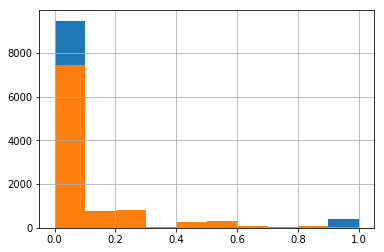

In [0]:
# short exploratory analysis
train.head()
train.bool_target.hist()
train.target.hist()

In [0]:
DATA_COLUMN = 'comment_text'
LABEL_COLUMN = 'bool_target'
label_list = [0, 1]

In [0]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)
# Use the InputExample class from BERT's run_classifier code to create examples from the data
dev_InputExamples = dev.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)


In [0]:
def create_tokenizer_from_hub_module(model_path):
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(model_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module(BERT_MODEL_PATH)

In [0]:
%%time
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, max_seq_length, tokenizer)
dev_features = bert.run_classifier.convert_examples_to_features(dev_InputExamples, label_list, max_seq_length, tokenizer)

In [0]:
class BERT(tf.layers.Layer):

    def __init__(self, n_fine_tune_layers=-1, output_representation='pooled_output', **kwargs):
        """
        :param output_representation: 'pooled_output' for CLS toke or 'sequence_output' for one-to-one outputs
        """
        assert output_representation in {"pooled_output", "sequence_output"}
        self.bert = None
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_representation = output_representation
        super(BERT, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(BERT_MODEL_PATH, trainable=self.trainable, 
                               name="{}_module".format(self.name))
        # Remove unused layers and set trainable parameters
        trainable_vars = [var for var in self.bert.variables 
                             if not "/cls/" in var.name 
                             and not "/pooler/" in var.name
                          ]

        # Select how many layers to fine tune
        if self.n_fine_tune_layers > 0:
          trainable_vars = trainable_vars[-self.n_fine_tune_layers :]

        # Add to trainable weights
        for var in trainable_vars:
          self._trainable_weights.append(var)
          
        # Update non-trainable weights
        for var in self.bert.variables:
          if var not in self._trainable_weights:
            self._non_trainable_weights.append(var)
          
        super(BERT, self).build(input_shape)

    def call(self, inputs):
        input_ids, input_mask, segment_ids = [K.cast(x, dtype="int32") for x in inputs]
        inputs = dict(input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids)
        out = self.bert(inputs=inputs, as_dict=True, signature='tokens')
        #return out[self.output_representation]
        if output_representation == "pooled_output":
          return out['sequence_output'][:, 0, :] # return the CLS embedding
        return out['sequence_output']


In [0]:
# Build model
#output_representation="sequence_output"
output_representation="pooled_output"

def build_model(max_seq_length, output_representation=output_representation): 
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = BERT(output_representation=output_representation, n_fine_tune_layers=3)(bert_inputs)
    if output_representation == "pooled_output":
      dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)
    elif output_representation == "sequence_output":
      dense = tf.keras.layers.GRU(128)(bert_output)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [0]:
def get_features(features):
  input_ids, input_masks, segment_ids, labels = [], [], [], []
  for f in features:
    input_ids.append(f.input_ids)
    input_masks.append(f.input_mask)
    segment_ids.append(f.segment_ids)
    labels.append(f.label_id)
  return (
    np.array(input_ids),
    np.array(input_masks),
    np.array(segment_ids),
    np.array(labels).reshape(-1, 1),
  )

train_input_ids, train_input_masks, train_segment_ids, train_labels = get_features(train_features)
dev_input_ids, dev_input_masks, dev_segment_ids, dev_labels = get_features(dev_features)

In [0]:
model = build_model(max_seq_length, output_representation=output_representation)

In [0]:
%%time

# Instantiate variables
initialize_vars(sess)

model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([dev_input_ids, dev_input_masks, dev_segment_ids], dev_labels),
    epochs=1,
    batch_size=32
)

In [0]:
# predict and evaluate
predictions = model.predict([dev_input_ids, 
                             dev_input_masks, 
                             dev_segment_ids]) # predictions before we clear and reload model

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(dev_labels, predictions)
print('ROC AUC: {:.4f}'.format(auc))

In [0]:
import csv
# save the predictions

model.save('BertModelRNN.h5')
tf.gfile.Copy('BertModelRNN.h5', '/BertModelRNN.h5')

predictions_path = 'bertmodel_rnn_predictions.csv'
resultFile = tf.gfile.Open(predictions_path, 'w')
wr = csv.writer(resultFile)
wr.writerows(predictions)